In [35]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_dependency_ecosystem"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field != pr_merged_key)]

df[independent_fields].describe()

class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f'{class_imbalance=}')

meta_header_count = 5

df.describe()

Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + EcosystemExperienceSubmitterPullReques

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality),ln(1 + IntegratorToSubmitterLinkIntensity),ln(1 + SubmitterToIntegratorLinkIntensity)
count,2.230290e+05,2.230290e+05,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,...,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000,223029.000000
mean,1.670070e+08,3.266915e+06,611.503419,0.715633,0.815345,0.542848,0.327010,0.368093,0.116051,0.313138,...,0.188078,0.302448,0.063116,0.108415,0.052536,0.096601,0.135184,0.115859,0.062972,0.077380
std,9.695130e+07,5.861662e+06,1639.543815,0.407933,0.282321,0.473776,0.448045,0.205063,0.067796,0.173791,...,0.147767,0.193840,0.113180,0.160227,0.113795,0.172470,0.105507,0.104483,0.130304,0.144173
min,6.235100e+04,4.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.476893e+07,2.473630e+05,44.000000,0.500000,0.800000,0.000000,0.000000,0.197221,0.075257,0.192488,...,0.089382,0.155067,0.000000,0.000000,0.000000,0.000000,0.058100,0.037447,0.000000,0.000000
50%,1.612981e+08,1.006620e+06,169.000000,0.952381,0.928571,0.833333,0.000000,0.363611,0.075257,0.323881,...,0.178763,0.310134,0.000000,0.000000,0.000000,0.000000,0.112566,0.089414,0.000000,0.000000
75%,2.456269e+08,3.680083e+06,543.000000,1.000000,1.000000,1.000000,0.918033,0.523389,0.119279,0.441188,...,0.296920,0.450264,0.117002,0.202881,0.000000,0.138630,0.189063,0.165960,0.038858,0.094846
max,3.617652e+08,5.746356e+07,49599.000000,1.000000,1.000000,1.000000,1.000000,0.980358,0.898782,0.996338,...,0.854348,0.886728,1.000000,1.000000,1.000000,1.000000,0.870413,0.865460,0.912889,0.918738


In [36]:
field = "ln(1 + IntraProjectSubmitterIssueSubmissionCount)"

from python_proj.utils.util import get_matching

coll_exp = r'.*(LinkIntensity|Weighted).*'
dep_exp = r'.*(?!.*Inversed).*Dependency.*'
eco_exp = r'(?!.*Dependency).*Ecosystem.*'
intra_exp = r'.*(?!.*Control).*Intra.*'
fields = list(get_matching(df.columns, dep_exp))

print(fields)
print(len(df))
for field in fields:
    print(len(df[df[field].gt(0)]))
    results = []
    prev = 0
    for i in range(1, 11):
        step = i / 10
        test_df = df[df[field].gt(prev).lt(step)]
        vals = test_df[pr_merged_key].value_counts()
        perc = vals[True] / (vals[True] + vals[False])
        perc = math.floor(perc * 10000) / 10000
        results.append(perc)
        prev = step
    print(f'{field}: {results}')

['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)']
223029
128954
DependencyEcosystemExperienceSubmitterPullRequestSuccessRate: [0.8527, 0.8526, 0.8522, 0.8519, 0.851, 0.8511, 0.8509, 0.8516, 0.8538, 0.8599]
79208
InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate: [0.8767, 0.8767, 0.8763, 0.

In [4]:
import copy

default_plot_settings = {
    'edgecolor': 'black',
    'color': "#e69d00"
}

default_plot_settings_2 = copy.deepcopy(default_plot_settings)
default_plot_settings_2['color'] = "#56b3e9"


def __fix_x_label_fontsize(__column):
    # Adjusts x-label's fontsize to fit the text.
    fig = plt.gcf()
    fig_width = fig.get_figwidth()
    xlabel_fontsize = int(fig_width * 100 / len(__column))
    ax = plt.gca()
    orig_fontsize = ax.xaxis.label.get_fontsize()
    ax.xaxis.label.set_fontsize(min(xlabel_fontsize, orig_fontsize))


def create_histogram(_df: pd.DataFrame, _column: str,
                     subfolder_name: str = "",
                     show_without_value = None):
    can_create_feature_histograms = True

    if not can_create_feature_histograms:
        return

    binary_fields = _df.select_dtypes(exclude='number').columns

    print(_column)
    plt.clf()
    entries = _df[_column]

    if _column in binary_fields:
        entries = _df[_column].replace({False: 0, True: 1})
        plt.xticks([0, 1], ['False', 'True'])
        plt.hist(entries, bins=2, **default_plot_settings)
        plt.ylabel('Frequency')
    # elif __column in shown_fields_without_zeroes:
    elif not show_without_value is None:
        _, bins, _ = plt.hist(entries, bins=30, alpha=1,
                              label="All Data", **default_plot_settings)
        ax: plt.Axes = plt.gca()
        ax.set_ylabel("Frequency")
        ax.set_xlabel(_column)
        __fix_x_label_fontsize(_column)

        filtered_data = _df[_column][_df[_column] != show_without_value]
        ax2 = ax.twinx()

        ax2.hist(filtered_data, bins, alpha=0.5,
                 label=f'Excl. {show_without_value}', **default_plot_settings_2)
        ax2.set_ylabel(f"Frequency (excl. x = {show_without_value})")
        ax2.set_zorder(10)
        plt.tight_layout()
    else:
        plt.hist(entries, bins=30, **default_plot_settings)
        plt.ylabel('Frequency')

    plt.xlabel(_column)
    __fix_x_label_fontsize(_column)
    plt.tight_layout()

    output_path = f"{figure_base_path}/distributions/{subfolder_name}/{_column}.png"
    safe_save_fig(output_path)


In [5]:
print(f'{len(df)=}\n')

binary_values = df['ControlIntegratedBySameUser'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')

binary_values = df['ControlPullRequestHasComments'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')

binary_values = df['ControlHasHashTagInDescription'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')

binary_values = df['ControlPullRequestHasCommentByExternalUser'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')


binary_values = df['SubmitterIsFirstTimeContributor'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')



len(df)=1224618

ControlIntegratedBySameUser
False    701400
True     523218
Name: count, dtype: int64
ratio=0.746

ControlPullRequestHasComments
True     763756
False    460862
Name: count, dtype: int64
ratio=1.657

ControlHasHashTagInDescription
False    822549
True     402069
Name: count, dtype: int64
ratio=0.489

ControlPullRequestHasCommentByExternalUser
False    912555
True     312063
Name: count, dtype: int64
ratio=0.342

SubmitterIsFirstTimeContributor
False    796000
True     428618
Name: count, dtype: int64
ratio=0.538



In [5]:
test_df = df[df['ln(1 + ControlPullRequestLifeTimeInMinutes)'].gt(0.150)]
print(f'{len(test_df)=}\n')

binary_values = test_df['ControlIntegratedBySameUser'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')

binary_values = test_df['ControlPullRequestHasComments'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')

binary_values = test_df['ControlHasHashTagInDescription'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')

binary_values = test_df['ControlPullRequestHasCommentByExternalUser'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')

binary_values = test_df['SubmitterIsFirstTimeContributor'].value_counts()
print(binary_values)
ratio = binary_values[True] / binary_values[False]
print(f'{ratio=:.03f}\n')


len(test_df)=1041259

ControlIntegratedBySameUser
False    661082
True     380177
Name: count, dtype: int64
ratio=0.575

ControlPullRequestHasComments
True     707108
False    334151
Name: count, dtype: int64
ratio=2.116

ControlHasHashTagInDescription
False    680818
True     360441
Name: count, dtype: int64
ratio=0.529

ControlPullRequestHasCommentByExternalUser
False    756102
True     285157
Name: count, dtype: int64
ratio=0.377

SubmitterIsFirstTimeContributor
False    649435
True     391824
Name: count, dtype: int64
ratio=0.603



In [6]:
print(test_df)

                  Project Name        ID  Submitter ID  PR Number   
0        0xProject/0x-monorepo  0.344426      0.036018   0.000518  \
1        0xProject/0x-monorepo  0.514439      0.302341   0.006870   
2        0xProject/0x-monorepo  0.518177      0.518344   0.007026   
3        0xProject/0x-monorepo  0.474870      0.103866   0.005038   
4        0xProject/0x-monorepo  0.652738      0.036018   0.016704   
...                        ...       ...           ...        ...   
1224612    zzo/browsermob-node  0.125749      0.146349   0.000217   
1224613    zzo/browsermob-node  0.032111      0.005961   0.000084   
1224614    zzo/browsermob-node  0.128335      0.243122   0.000229   
1224616    zzo/browsermob-node  0.528562      0.036526   0.000350   
1224617    zzo/browsermob-node  0.546676      0.030540   0.000374   

                    Closed At  PullRequestIsMerged   
0        2017-06-08T16:31:22Z                 True  \
1        2018-05-25T00:24:53Z                 True   
2        

In [8]:
print(len(test_df))

binary_values = test_df['ControlPullRequestHasComments'].value_counts()
print(binary_values)
print(binary_values[True] / binary_values[False])

616125
ControlPullRequestHasComments
True     369933
False    246192
Name: count, dtype: int64
1.5026199064145058


In [17]:
# test_df = df[['ln(1 + ControlPullRequestLifeTimeInMinutes)']]
# test_df.describe()
test_df = df[df.columns[meta_header_count:]].copy()
test_df.describe()

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount),...,ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter),ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,...,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000,362343.000000
mean,0.638262,0.429836,0.098377,0.057805,0.447752,0.118057,0.341987,0.194297,0.164654,0.169333,...,0.209197,0.047549,0.181902,0.054584,0.151209,0.088815,0.055409,0.133098,0.125631,0.106253
std,0.434767,0.449846,0.290017,0.225420,0.186658,0.067834,0.180198,0.164552,0.179353,0.205255,...,0.181524,0.120706,0.186127,0.116908,0.170321,0.144998,0.128354,0.161895,0.111262,0.107006
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.311284,0.075257,0.214287,0.093185,0.000000,0.000000,...,0.109693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040537,0.025799
50%,0.904762,0.105263,0.000000,0.000000,0.460687,0.075257,0.345677,0.147695,0.091622,0.100113,...,0.173859,0.000000,0.118269,0.000000,0.111148,0.000000,0.000000,0.070165,0.097465,0.074010
75%,1.000000,0.941176,0.000000,0.000000,0.582534,0.150513,0.479262,0.309554,0.274867,0.300340,...,0.329079,0.000000,0.305720,0.000000,0.266996,0.124825,0.000000,0.242732,0.182317,0.154860
max,1.000000,1.000000,1.000000,1.000000,0.988177,0.993329,0.989459,0.777565,0.960735,0.992412,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.917726,0.915254


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                                             variable        VIF
0                                 PullRequestIsMerged   7.201555
1                         ControlIntegratedBySameUser        NaN
2                       ControlPullRequestHasComments   4.158362
3                      ControlHasHashTagInDescription   1.771859
4         IntraProjectSubmitterPullRequestSuccessRate   6.700448
5   EcosystemExperienceSubmitterPullRequestSuccess...   4.441244
6   DependencyEcosystemExperienceSubmitterPullRequ...   3.738619
7   InversedDependencyEcosystemExperienceSubmitter...   4.041141
8                     SubmitterIsFirstTimeContributor   2.197819
9          ControlPullRequestHasCommentByExternalUser   1.620663
10        ln(1 + ControlPullRequestLifeTimeInMinutes)   6.094795
11        ln(1 + ControlNumberOfCommitsInPullRequest)   4.292691
12  ln(1 + ControlIntraProjectPullRequestExperienc...   8.051493
13  ln(1 + IntraProjectSubmitterPullRequestSubmiss...  15.598059
14  ln(1 + IntraProjectSu

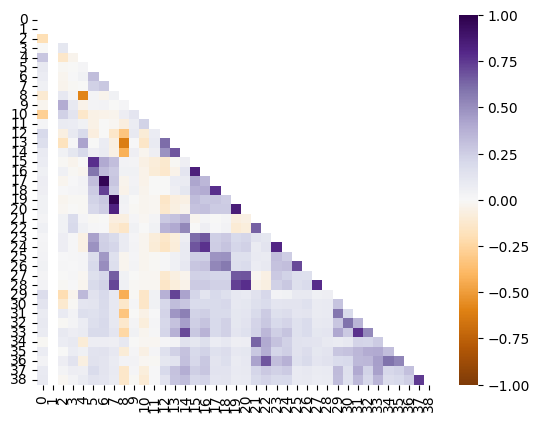

In [18]:
# Calculates VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


def change_bin_fields_to_float(__df: pd.DataFrame):
    repl_df = __df.copy()
    value_mapper = {False: 0, True: 1}

    binary_fields = __df.select_dtypes(exclude='number')
    for feature in binary_fields:
        repl_df[feature] = __df[feature].replace(value_mapper)

    return repl_df


# tested_predictors = df[independent_fields].drop(multicollinear_fields, axis=1)
tested_predictors = change_bin_fields_to_float(test_df)

vif_df = pd.DataFrame()
vif_df['variable'] = tested_predictors.columns
vif_df['VIF'] = [variance_inflation_factor(tested_predictors.values, i)
                 for i in range(tested_predictors.shape[1])]

print(vif_df)


# Finds problematic VIF
problematic_vif = vif_df[vif_df['VIF'] >= 5]
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:")
print(problematic_vif)


# Visualizes VIF
import seaborn as sb
import json
from python_proj.utils.util import SafeDict

tick_labels = list(range(len(vif_df)))
corr = test_df.corr(method='spearman')
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(corr, cmap="PuOr",
                      xticklabels=tick_labels, yticklabels=tick_labels,
                      mask=mask,
                      vmin=-1, vmax=1)


def get_correlating_fields(coof_threshold, corr):
    print(f'{coof_threshold=}')
    correlating_fields = []
    # print(corr)
    for rowIndex, row in corr.iterrows():  # iterate over rows
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    print("Correlating pairs:\n" + json.dumps(correlating_fields, indent=4) + "\n")
    return correlating_fields


correlating_fields = get_correlating_fields(coof_threshold=0.5, corr=corr)

# Identify problematic fields:
presence_counts = SafeDict(default_value=0)
for (field_a, field_b, _) in correlating_fields:
    presence_counts[field_a] += 1
    presence_counts[field_b] += 1
pc = list(presence_counts.items())
pc.sort(key=lambda x: x[1])
# print(f'Variable correlation frequency:\n{json.dumps(pc, indent=4)}\n')

# Generate transitive closures


def unify_if_overlapping(collections: list[list]):
    # gather the lists that do overlap
    overlapping = [x for x in collections if
                   any(x_element in [y for k in collections
                                     if k != x for y in k]
                       for x_element in x)]
    # flatten and get unique
    overlapping = sorted(list(set([z for x in overlapping for z in x])))
    # get the rest
    non_overlapping = [x for x in collections if all(
        y not in overlapping for y in x)]
    # use the line bellow only if merged non-overlapping elements are desired
    # non_overlapping = sorted([y for x in non_overlapping for y in x])
    non_overlapping.append(overlapping)
    return non_overlapping


correlating_no_coof = [(a, b) for (a, b, _) in correlating_fields]
unified = unify_if_overlapping(correlating_no_coof)
print("Transitive closure of correlating pairs:\n" +
      json.dumps(unified, indent=4))
